In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import scipy.stats as stats

# Exercise 2

In this exercise, we were given a dataset of points in a 2D space. Each point correspond to a nose and we have also the information that that nose might detect or not an odour emmited from an unknown location. We would like to find the most likely position for this source.

## Useful functions

First, a few useful functions. The first one will just return the euclidean distance between two points.

In [2]:
def distance(x1, x2):
    return math.sqrt((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)

Now, functions to read the dataset and to bild the grid.

In [3]:
def read_data(file):
    with open(file) as f:
        lines = f.readlines()
        
    return [[float(entry) for i, entry in enumerate(line.split("\t"))] for line in lines]

def build_map(data, boundaries, rate):
    n_points = int((boundaries[1] - boundaries[0])/rate)
    
    grid = [[(x-n_points/2)*rate,(y-n_points/2)*rate] for x in range(n_points) for y in range(n_points)]
    
    return grid

The map is as follows (Red dots are the noses that detected the odor and the blue are the ones who did not)

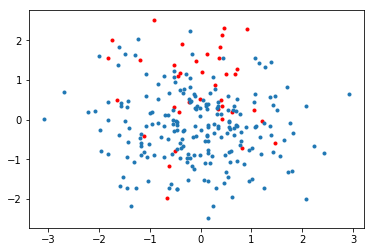

In [4]:
data = read_data("data.txt")
grid = build_map(data, [-3.3, 3.3], 0.01)
plt.plot([x[0] for x in data if x[2]==1], [x[1] for x in data if x[2]==1], 'r.')
plt.plot([x[0] for x in data if x[2]==0], [x[1] for x in data if x[2]==0], '.')
plt.show()

And to finish, a function that takes one point as input and calculates its likelihood

In [5]:
def compute_likelihood(point, data):
    likelihood = 1
    
    for nose in data:
        mu = math.exp(-distance(point, nose[:-1]))
        likelihood *= (mu**(nose[-1]))*((1 - mu)**(1 - nose[-1]))
    
    return likelihood

## Maximum Likelihood Estimation

Using these functions, we must find the point most likely to be the odor source. The strategy is as follows: For each point of the grid, we will iterate through all the noses, computing each individual likelihood and then multiplying them all. Then, we will return the point with the highest likelihood value.

In [6]:
def mle(grid, data):
    maximum_likelihood = 0
    count = 0
    new_grid = []
    print(len(grid))
    for point in grid:
        count += 1
        if count%10000 == 0:
            print("Progress: {}%".format(count*100/len(grid)))
        likelihood = compute_likelihood(point, data)
        new_grid.append([point[0], point[1], likelihood])
        if likelihood > maximum_likelihood:
            maximum_likelihood = likelihood
            ml_point = point

    return ml_point, maximum_likelihood, new_grid

ml_point, maximum_likelihood, new_grid_mle = mle(grid, data)
print("Maximum likelihood: {}\tPoint: {}".format(maximum_likelihood, ml_point))

435600
Progress: 2.295684113865932%
Progress: 4.591368227731864%
Progress: 6.887052341597796%
Progress: 9.182736455463727%
Progress: 11.47842056932966%
Progress: 13.774104683195592%
Progress: 16.069788797061523%
Progress: 18.365472910927455%
Progress: 20.66115702479339%
Progress: 22.95684113865932%
Progress: 25.252525252525253%
Progress: 27.548209366391184%
Progress: 29.843893480257115%
Progress: 32.13957759412305%
Progress: 34.43526170798898%
Progress: 36.73094582185491%
Progress: 39.02662993572085%
Progress: 41.32231404958678%
Progress: 43.61799816345271%
Progress: 45.91368227731864%
Progress: 48.209366391184574%
Progress: 50.505050505050505%
Progress: 52.80073461891644%
Progress: 55.09641873278237%
Progress: 57.3921028466483%
Progress: 59.68778696051423%
Progress: 61.98347107438016%
Progress: 64.2791551882461%
Progress: 66.57483930211203%
Progress: 68.87052341597796%
Progress: 71.16620752984389%
Progress: 73.46189164370982%
Progress: 75.75757575757575%
Progress: 78.0532598714417%
Pr

If we plot the obtained point with the data, we get:

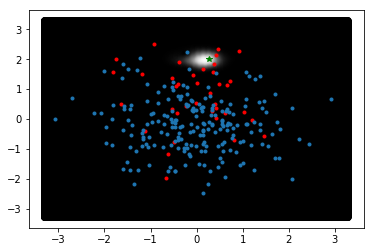

In [7]:
plt.scatter([x[0] for x in new_grid_mle], [x[1] for x in new_grid_mle], 
            c=[x[2] for x in new_grid_mle], 
            cmap=mpl.cm.Greys_r)
plt.plot([x[0] for x in data if x[2]==1], [x[1] for x in data if x[2]==1], 'r.')
plt.plot([x[0] for x in data if x[2]==0], [x[1] for x in data if x[2]==0], '.')
plt.plot([ml_point[0]], ml_point[1], 'g*')
plt.show()

## Maximum a posteriori

Now the strategy is almost the same: We will still iterate through every point in the grid multipliying the likelihoods for each nose. But we will multiply the result by a gaussian with mean $g$ and covariance matrix $\sigma I_2$, where $g$ and $\sigma$ are yet unknown.

We will take a guess on their values. The value of $g$ will be the mean of the noses that detected the odor. The value of $\sigma$ will be the highest value between the standard deviations of the two dimensions (Still taking into account only the noses that detected the odor).

Let's build functions to compute each hyperparameter.

In [8]:
def find_mean(data):
    total = sum_x = sum_y = 0
    for point in data:
        if point[2] == 1.0:
            total += 1
            sum_x += point[0]
            sum_y += point[1]
    
    return [sum_x/total, sum_y/total]

def find_sd(data, mean):
    total = sd_x = sd_y = 0
    for point in data:
        if point[2] == 1.0:
            total += 1
            sd_x += (point[0] - mean[0])**2
            sd_y += (point[1] - mean[1])**2
    
    return max(math.sqrt(sd_x/total), math.sqrt(sd_y/total))

g = find_mean(data)
sigma = find_sd(data, g)

print(g, sigma)

[-0.043577064315789484, 0.7908343316578947] 1.0284822419346629


The gaussian that we will use as prior will be

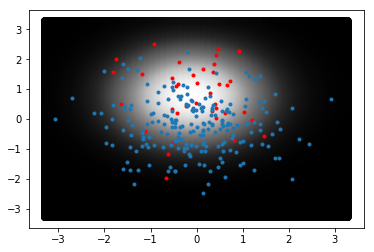

In [9]:
def bi_gaussian(x, mean, sigma):
    return stats.multivariate_normal.pdf(x, mean=mean, cov=sigma)

plt.scatter([x[0] for x in grid], [x[1] for x in grid], 
            c=[bi_gaussian(x, g, sigma) for x in grid], 
            cmap=mpl.cm.Greys_r)
plt.plot([x[0] for x in data if x[2]==1], [x[1] for x in data if x[2]==1], 'r.')
plt.plot([x[0] for x in data if x[2]==0], [x[1] for x in data if x[2]==0], '.')
plt.show()

Now we implement the MAP function

In [10]:
def mapost(data, grid, g, sigma):
    maximum_aposteriori = 0
    count = 0
    print(len(grid))
    new_grid = []
    for point in grid:
        count += 1
        if count%10000 == 0:
            print("Progress: {}%".format(count*100/len(grid)))
        likelihood = compute_likelihood(point, data)
        prior = bi_gaussian(point[:-1], g, sigma)
        new_grid.append([point[0], point[1], likelihood*prior])
        if likelihood*prior > maximum_aposteriori:
            maximum_aposteriori = likelihood
            map_point = point

    return map_point, maximum_likelihood, new_grid

map_point, maximum_likelihood, new_grid = mapost(data, grid, g, sigma)
print(map_point, maximum_likelihood)

435600
Progress: 2.295684113865932%
Progress: 4.591368227731864%
Progress: 6.887052341597796%
Progress: 9.182736455463727%
Progress: 11.47842056932966%
Progress: 13.774104683195592%
Progress: 16.069788797061523%
Progress: 18.365472910927455%
Progress: 20.66115702479339%
Progress: 22.95684113865932%
Progress: 25.252525252525253%
Progress: 27.548209366391184%
Progress: 29.843893480257115%
Progress: 32.13957759412305%
Progress: 34.43526170798898%
Progress: 36.73094582185491%
Progress: 39.02662993572085%
Progress: 41.32231404958678%
Progress: 43.61799816345271%
Progress: 45.91368227731864%
Progress: 48.209366391184574%
Progress: 50.505050505050505%
Progress: 52.80073461891644%
Progress: 55.09641873278237%
Progress: 57.3921028466483%
Progress: 59.68778696051423%
Progress: 61.98347107438016%
Progress: 64.2791551882461%
Progress: 66.57483930211203%
Progress: 68.87052341597796%
Progress: 71.16620752984389%
Progress: 73.46189164370982%
Progress: 75.75757575757575%
Progress: 78.0532598714417%
Pr

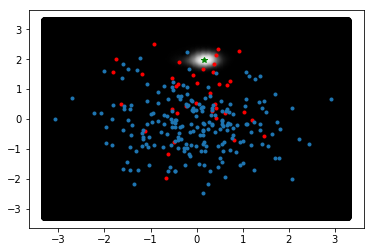

In [11]:
plt.scatter([x[0] for x in new_grid], [x[1] for x in new_grid], 
            c=[x[2] for x in new_grid], 
            cmap=mpl.cm.Greys_r)
plt.plot([x[0] for x in data if x[2]==1], [x[1] for x in data if x[2]==1], 'r.')
plt.plot([x[0] for x in data if x[2]==0], [x[1] for x in data if x[2]==0], '.')
plt.plot([map_point[0]], map_point[1], 'g*')
plt.show()